# Intro to Time Series Forecasting and Evaluation 

## Introduction 

This is the second in a series of two notebooks on an introduction to time series forecasting. The last notebook outlined concepts of time series analysis such as time series processesing, decomposition, correlation and stationairity. In this notebook, we will discuss an intro to time series forecasting and evaluation. This notebook is particularly focused on the setup for forecasting problems and evaulation. Future notebooks will go into depth on specific forecasting methods. 

## Outline

- **Intro to Forecasting**
    - Univariate Forecasting 
        - Exponential Smoothing
    - Multivariate Forecasting 

- **Forcasting Evaluation**
    - Metrics 
    - Evaluation Methodologies

- **Conclusion** 

- **References**

## Environment Configuration and Package Imports

**Please Note after installing the dependencies into the notebook you must restart the kernel. Simply, go under the Runtime tab and select Restart and Run All. This must be done only after the first time executing the notebook in a given session.** 

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab: 
    !pip install darts
    !pip install pyyaml==5.4.1
    !pip install -U matplotlib

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pywt

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from darts.models import ExponentialSmoothing
from darts import TimeSeries
from darts.datasets import GasRateCO2Dataset
from darts.datasets import AirPassengersDataset
from darts.dataprocessing.transformers import MissingValuesFiller

## Intro to Time Series Forecasting

### Univariate Time Series Forecasting

Univaritate forecasting involves predicting future values given past observations of a time series. More specifically, given a lookback window of length $T$ and a forecasting horizon of length $H$, the univariate time series forecasting problem is to find  function $f: \mathbb{R}^{T} \to \mathbb{R}^H$: 

\begin{align}
    \hat{y} = f(x) \approx y
\end{align}

where $x \in \mathbb{R}^T = [y_{1} \cdots y_{T}]$ is an input vector of observations over the lookback window, $y \in \mathbb{R}^H = [y_{T} \cdots y_{T+H}]$ is the output vector. $f$ is parametized by $\theta$ which determine the output $\hat{y}$ given an input $x$. $\theta$ is learned to mimimize the prediction loss of the model $L$ over training portion of the time series. The resulting model $f$ is evaluated on an unseen portion of the time series to estimate the out-of-sample performance.  

To solidify this notion, we will train and evaluate an Exponential Smoothing Forecasting model on the Air Passenger Dataset. The Air Passenger dataset tracks the amount of commerical airplane passengers $x_i$ by month $i$. We can use the [`darts.datasets.AirPassengersDataset.load`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function to load the dataset: 

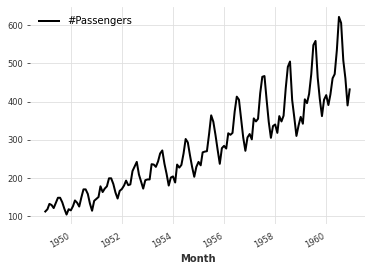

In [3]:
ts = AirPassengersDataset().load()
ts.plot()

With our dataset in place, we can select a univariate forecasting model to train and evaluate. For this example, we consider an [Exponential Smoothing Forecasting model](https://en.wikipedia.org/wiki/Exponential_smoothing) a seminal approach to time series forecasting. 

#### Aside: Exponential Smoothing
Exponential smoothing (ES) models generate predictions $\hat{y}$ as linear combination of past observations $x_1 ,\cdots, x_T$ with exponentially decreasing weights. The implicit assumption of ES models is that the dependence of current observation on previous observations decays across time. In this way, ES models are extremely efficient - requiring only the previous smoothed value and the current time series value to compute a given prediction. This makes them favourable for use cases with low latency requirements. In the following, we will explore some common variation of ES models. 

#### Simple Exponential Smoothing (Brown Method) 
In the simplest case, the smoothed series value at time $t$,  $l_t$,  is a weighted average of the previous smoothed value $l_{t-1}$ and the current time series value $x_t$: 

\begin{equation}
l_t = \alpha x_t + (1-\alpha) l_{t-1} \quad \text{where} \quad \alpha \in (0,1)
\end{equation}

Given this, The forecast $h$ steps ahead is defined by:
\begin{equation}
\hat{y}_{t+h} = l_t
\end{equation}

which means simply that out of sample, our forecast is equal to the most recent value of the smoothed series. A few things to note about Simple Exponential Smoothing: 
- Smoothing factor $\alpha$ controls tradeoff between recency and smoothing
- $\alpha$ can be set manually or estimated 
- Smoothing needs some time to catch up with the dynamics of your time series. A rule of thumb for a reasonable sample size is that you need $\frac{3}{\alpha}$ observations.

#### Double Exponential Smoothing (Holt Method) 

Simple Exponential smoothing gives us an estimate of the level of the time series which acts as an intercept. In Double Exponential smoothing, we add another component into the forecastng function - the trend. Similar to the level, we apply exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. This can be expresed as follows: 

\begin{equation}
l_t = \alpha x_t + (1 - \alpha) (l_{t-1} + g_{t-1}) \quad \text{where} \quad \alpha \in (0,1) \\
g_t = \beta (l_t - l_{t-1}) + (1- \beta) g_{t-1} \quad \text{where} \quad \beta \in (0,1)
\end{equation}

Given this, the forecast $h$ steps ahead is defined by
\begin{equation}
\hat{y}_{t+h} = l_t + h g_t
\end{equation}

The forecast function is no longer flat but trending: $h$-step-ahead forecast is equal to the last estimated level plus $h$ times the last estimated trend value. A few things to note about Double Exponential Smoothing: 

- The first equation describes the level of the series which depends on the current value of the series, the previous level value and the previous trend value. 
- The second equation describes the trend, which depends on the level changes at the current step and on the previous value of the trend. 
- The values of $\alpha$ and $\beta$ are set based on expert judgement or estimated (jointly) from the data. 

#### Triple Exponential Smoothing (Holt-Winters Method) 
A natural extension of Double Exponential smoothing is Triple Exponential Smoothing. In triple exponential smoothing, we include a trend, level as well as a seasonal component with periond $L$ into the forcasting function: 

\begin{equation}
l_t = \alpha (x_t - s_{t - L}) + (1 - \alpha) (l_{t-1} + g_{t-1}) \quad \text{where} \quad \alpha \in (0,1) \\
g_t = \beta (l_t - l_{t-1}) + (1 - \beta) g_{t-1} \quad \text{where} \quad \beta \in (0,1) \\
s_t = \gamma (x_t - l_{t-1} - g_{t-1})+ (1 - \gamma) s_{t-L} \quad \text{where} \quad \gamma \in (0,1)
\end{equation}

Given this, the forecast $h$ steps ahead is defined by:
\begin{equation}
\hat{y}_{t+h} = l_t + h g_t + s_{(t-L + h) \;\; mod \;\;  L }
\end{equation}

The forecast function consists of a level, trend and seasonal component. A few things to note about Triple Exponential Smoothing: 
- The seasonal component explains repeated variations around intercept and trend, and it will be specified by the period. 
- For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components value of the trend. 
- The values of $\alpha$, $\beta$ and $\gamma$ are set based on expert judgement or estimated (jointly) from the data.

We can create an Holt Winters Exponential Smoothing Forecasting Model by initializing the [`darts.models.ExponentialSmoothing`](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html) object. Subsequently, the model can be fit by passing the `TimeSeries` object to the `fit` method of the initialized model. 

In [4]:
es_model = ExponentialSmoothing()
es_model.fit(ts)

Predictions can be generated from the fit model by calling the `predict` method with the length of the forecasting horizon as an argument. Here we predict the 12 monthly observations following the data used to fit the model and plot the result in blue: 

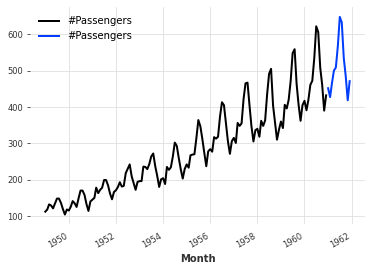

In [5]:
pred_es = es_model.predict(12)
ts.plot()
pred_es.plot()

### Multivariate Forecasting 

Multivariate forecasting involves predicting future values given past observations of a set of time series. More specifically, given a lookback window of length $T$, a forecasting horizon of length $H$ and a set of $K$ time series, the multivariate time series forecasting problem is to find  function $f: \mathbb{R}^{TxK} \to \mathbb{R}^{HxK}$: 

\begin{align}
    \hat{Y} = f(X) \approx Y
\end{align}

where $X \in \mathbb{R}^{TxK}$ is a matrix where each column is a sequence of observations over the lookback window for a specific time series and $Y \in \mathbb{R}^{HxK} $ is the output matrix where each column is the output sequence over the forecasting horizon for a specific time series. 

Similar to univariate forecasting, $f$ is parametized by $\theta$ which determine the output $\hat{y}$ given an input $x$. $\theta$ is learned to mimimize the prediction loss of the model $L$ over training portion of the time series. The resulting model $f$ is evaluated on an unseen portion of the time series to estimate the out-of-sample performance. 

This serves as a preliminary discussion of multivariate forecasting. In the following session, methods for multivariate forecasting will be discussed in detail.





### Covariates

Strictly relying on the history of a time series to predict its future is often suboptimal. In these cases, its beneficial to include covariates into the forecasting model. Covariates are exogenous time series that influence target time series. Covariates can be divided into the following two categories: 

- **Past Covariates**: time series whose past values are known at prediction time. Those series often contain values that have to be observed to be known.

- **Future Covariates**: Future covariates are time series whose future values are known at prediction time. Often, the past values of future covariates are known as well. 

To make this more concrete, the illustration below depicts the relationship between past covariates, future covariates and the target time series: 

<p align="center">
<img width="750" alt="Covariates" src="https://user-images.githubusercontent.com/34798787/211891654-058129b8-3e44-4353-b97b-49946e6b88b5.png"> 
</p> 

Only certain forecasting models support exogenous variables such as [Neural Prophet](https://neuralprophet.com/), [SARIMAX](https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/), [DeepAR](https://arxiv.org/abs/1704.04110). Some of these methods will be explained in detail during future notebooks. 

## Forecasting Evaluation

### Metrics 

Once the chosen model has been fit to the dataset, it must evaluated on unseen data to assess the out of sample performance. There are numerous metrics that are used including [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error), [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) and [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error). Given a forecast $y \in R^N$ and corresponding ground truth $\hat{y} \in R^N$, the metrics are defined as follows: 

<p align="center">
<img width="1000" alt="Covariates" src="https://user-images.githubusercontent.com/34798787/211632073-40e73186-39f3-4b7f-9fa2-b629cb55af66.png"> 
</p>

The [`darts.metrics.metrics`](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html) module contains the aformentioned metrics and more. These metrics can be easily used to evaluate the forecasts generated by our model as we will see below. 

### Evaluation Methodologies
Besides metrics, another central component of evaluation is determine how to split the data into training and testing. The most common approach is to allocate the first portion of the time series to the training set and the latter part to the testing set. This is a familiar data splitting scheme for ML practitioners. It is conservative with respecto to data leakage and generalizability estiamtion. One downside of this approach is that the model does not learn from the most recent observation.  We can split a [`darts.TimeSeries`](https://unit8co.github.io/darts/generated_api/darts.timeseries.html) object in this manner by calling the [`split_before`](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.split_before) method with the proportion of the data to be alllocated to the train set. 

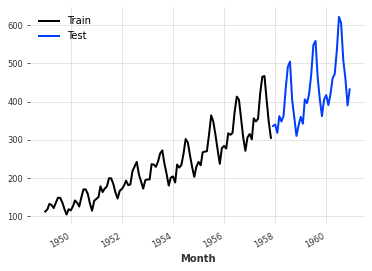

In [10]:
ts_train, ts_test = ts.split_before(.75)
ts_train.plot(label="Train")
ts_test.plot(label="Test")

We can now fit a model on the train set and subsequently plot the prediction results on the test set: 

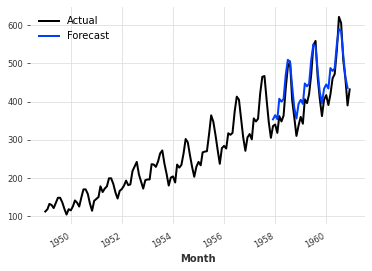

In [7]:
es_model = ExponentialSmoothing()
es_model.fit(ts_train)

forecast = es_model.predict(36)
ts.plot(label="Actual")
forecast.plot(label="Forecast")


The forecast can be evaluated with the metrics defined in the [`darts.metrics.metrics`](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html). In particular, we will evaulate the forecast using MAE, MSE and MAPE: 

In [8]:
from darts.metrics.metrics import mae, mse, mape

mae_score = mae(ts_test, forecast)
mse_score = mse(ts_test, forecast)
mape_score = mape(ts_test, forecast)

print(f"MAE: {mae_score}    MSE: {mse_score}    MAPE: {mape_score}")

MAE: 30.58656732050072    MSE: 1193.5935888751771    MAPE: 7.812233620065577


Another more sophisticated evaulation methodology is to use [rolling cross validation](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4#:~:text=The%20method%20that%20can%20be,for%20the%20forecasted%20data%20points.). In rolling cross validation, multiple models are fit and evaulated using different train and test sets. In particular, the datasets are generated using an expanding window approach and the results are averaged to get a single estimate. The illustation below helps depict the concept of rolling cross validation: 

<p align="center">
<img width="750" alt="Covariates" src="https://user-images.githubusercontent.com/34798787/211639665-7eaa75f7-231c-4d8f-8c5d-0ec7dcee56c0.png"> 
</p>

In this way, we are evaulating the approach as opposed to a single model. Additionally, unlike the previous evaluation methodology, the model is able to learn from the must recent observations. However, there are many subtle design choices such as how to weight past performance compared to more recent performance. Furthermore, training multiple models is computationally intensive, especially for deep learning based approaches.


[darts](https://unit8.com/resources/darts-time-series-made-easy-in-python/) makes it easy to realize rolling cross validation using the [`historical_forecast`](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.baselines.html#darts.models.forecasting.baselines.NaiveDrift.historical_forecasts) method odf the model. It takes a time series, a starting point and a forecast horizon. It returns the [`darts.TimeSeries`](https://unit8co.github.io/darts/generated_api/darts.timeseries.html) containing the historical forecasts would have been obtained when using the model to forecast the series with the specified forecast horizon, starting at the specified timestamp using an expanding window strategy:


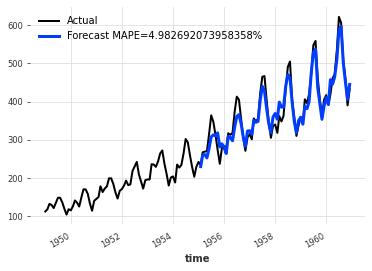

In [9]:
es_model = ExponentialSmoothing()
backtest = es_model.historical_forecasts(ts, start=.5, forecast_horizon=3)
err = mape(backtest, ts)
ts.plot(label="Actual")
backtest.plot(lw=3, label=f"Forecast MAPE={err}%")

## Conclusion 

In this notebook an introduction to time series forecasting was provided. Topics we covered include: 
- Univariate forecasting setup and Multivariate forecasting setup
- Including covariates to enhance performance
- Metrics to evaulate accuracy of forecasts
- Forecasting evaluation methodologies

## Resources
- [Darts: Time Series Made Easy in Python](https://unit8.com/resources/darts-time-series-made-easy-in-python/)
- [Training Forecasting Models on Multiple Time Series with Darts](https://unit8.com/resources/training-forecasting-models/)
- [Time Series Forecasting Using Past and Future External Data with Darts](https://unit8.com/resources/time-series-forecasting-using-past-and-future-external-data-with-darts/)
- [Time Series Forecasting: Data, Analysis, and Practice](https://neptune.ai/blog/time-series-forecasting)

## Next Steps
- Apply techniques for time series forecasting to relevant dataset
- Explore the univariate forecasting method demos in the [forecasting-bootcamp repo](https://github.com/VectorInstitute/forecasting-bootcamp/tree/main/demos) 
- Dive deeper into the topics we explored in the following notebooks: 
    - [TS-1a: Smoothing Methods](https://www.kaggle.com/code/konradb/ts-1a-smoothing-methods/notebook)
    - [TS-1b: Prophet](https://www.kaggle.com/code/konradb/ts-1b-prophet/notebook)
    - [TS-2: ARMA Methods](https://www.kaggle.com/code/konradb/ts-2-linear-vision?scriptVersionId=101499413)
    